# Jupyter Notebook for Neuroblastoma classifier models using RNA Seq data.
### Author - Muthukumaraswami Sivaswami (1833616)



This analysis was done on a local machine running Python 3.11.8. Please ensure that you have the right version of Python installed on your machine, so that all the required libraries are installed and can be imported.

First, let's take a look at log2FPKM.tsv. This file contains Normalized FPKM/transcript per million (TPM) values in log2 scale. This will be our main expression data file for analysis.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#importing the log2FPKM.tsv file, containing the RNA Seq data
log2FPKM_df = pd.read_csv('log2FPKM.tsv', sep='\t').rename({'00gene_id':'gene_id'},axis=1)

Now, let's run some sanity checks and look at the data.

In [3]:
#checking the shape of the data
print(f'log2FPKM_df shape: {log2FPKM_df.shape}') 

log2FPKM_df shape: (23146, 499)


We can see that our data has 23146 rows and 499 columns. Let's take a look at the first 5 rows of the data.

In [4]:
#checking the first few rows
log2FPKM_df.head()

,gene_id,NB001,NB002,NB003,NB004,NB005,NB006,NB007,NB008,NB009,...,NB489,NB490,NB491,NB492,NB493,NB494,NB495,NB496,NB497,NB498
0,1/2-SBSRNA4,0.834381,0.743094,0.909414,0.795775,0.905540,0.869154,1.811352,0.599240,0.981855,...,0.997977,1.003559,0.842437,1.057873,0.805515,0.491331,0.868249,0.911379,0.660139,1.152988
1,A1BG,1.910053,0.941996,1.950857,1.989477,1.942946,1.927608,1.617745,2.161291,1.436439,...,2.336929,2.836360,1.205317,2.439868,1.649027,1.451425,1.493852,1.641241,1.994978,1.289534
2,A1BG-AS1,1.453191,0.640614,1.156765,1.525277,1.365043,0.899212,1.304178,1.189205,0.771248,...,1.182908,1.367371,0.643751,1.096815,0.925425,0.933275,1.208723,0.904511,1.529221,1.102866
3,A1CF,0.005102,0.005902,0.005192,0.000000,0.025347,0.005682,0.000000,0.000000,0.021880,...,0.024298,0.007295,0.000000,0.006678,0.005746,0.004998,0.004853,0.000000,0.022780,0.018720
4,A2LD1,0.580151,0.738233,0.927667,0.936497,0.924853,0.739038,1.018705,0.546324,0.666877,...,0.673627,1.401265,0.837443,0.939849,0.743496,0.957837,0.812093,0.488748,1.068072,0.782887


This shows that the first column is simply sample IDs. It is not relevant for our analysis, so we will ignore it, for now.

Now, let's inspect the data by info.

In [5]:
log2FPKM_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23146 entries, 0 to 23145
Columns: 499 entries, gene_id to NB498
dtypes: float64(498), object(1)
memory usage: 88.1+ MB


In [6]:
#checking for missing values
log2FPKM_df.isnull().sum()

gene_id    0
NB001      0
NB002      0
NB003      0
NB004      0
          ..
NB494      0
NB495      0
NB496      0
NB497      0
NB498      0
Length: 499, dtype: int64

Our data has no missing values, which is great for a more robust downstream analysis.

Let's now do a little exploration of the data. We can start by looking at a correlation matrix.

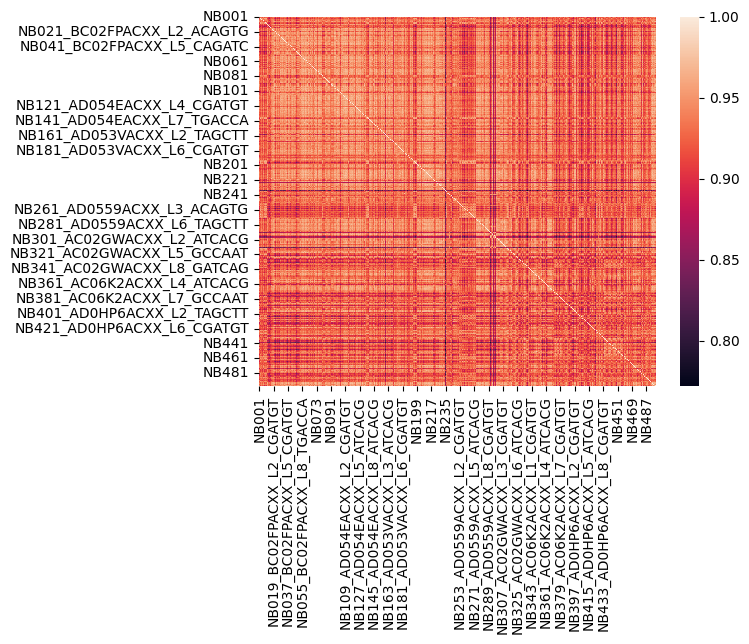

In [7]:
# Set index  
log2FPKM_df.set_index('gene_id', inplace=True)

# Calculate correlation directly
corr = log2FPKM_df.corr() 

# Heatmap  
sns.heatmap(corr)
plt.savefig('corr_heatmap.png')

The correlation values across most gene pairs appear normally distributed around 0 as expected, with no widespread strong correlations. This indicates good variability in the data.

Highly correlated genes are not obvious, which could signify technical artifacts like batch effects from sequencing or sample handling. The correlations appear randomly distributed and mixed.

Overall the heatmap provides confidence that the data is clean and ready for further analysis.

Next, let's just plot the data to see if there are any outliers.
I'll be using tSNE, which is particularly useful in visualizing data with high dimensionality.

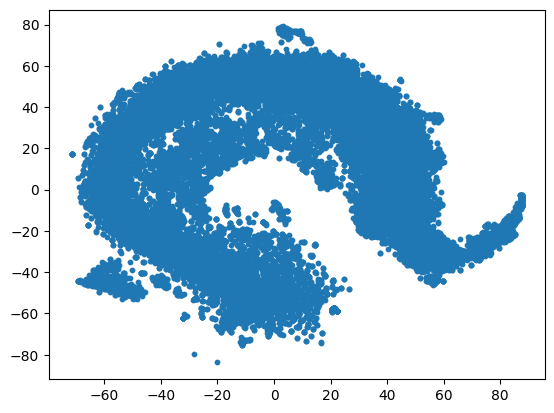

In [8]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0).fit_transform(log2FPKM_df) 

plt.scatter(tsne[:,0], tsne[:,1], s=10)
plt.savefig('tsne.png')

The plot shows that there is one cluster of data, with only one cluster of outliers. The plot doesn't really indicate any meaningful pattern in the data, unfortunately.

I'll try and change the perplexity value and learning rate to see how that affects the plot.

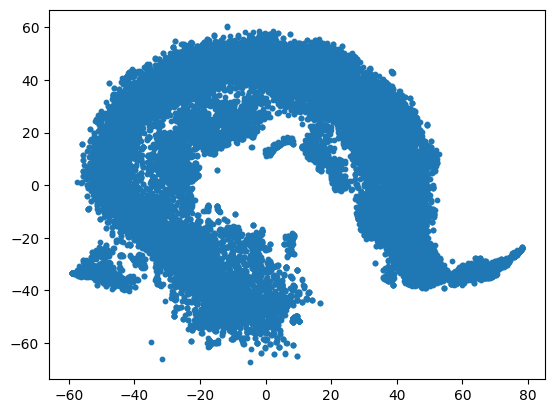

In [9]:
tsne = TSNE(n_components=2,perplexity=50,learning_rate=400, random_state=0).fit_transform(log2FPKM_df) 

plt.scatter(tsne[:,0], tsne[:,1], s=10)
plt.savefig('tsne2.png')

That doesn't seem to have changed the distribution much at all. I'll be moving on to looking at the provided clinical data.

In [10]:
#importing patientInfo.tsv
patientInfo_df = pd.read_csv('patientInfo.tsv', sep='\t')

Let's do our usual sanity checks.

In [11]:
#checking the shape of the clinical data
print(f'patientInfo_df shape: {patientInfo_df.shape}')

patientInfo_df shape: (498, 7)


We can see that the data has 498 samples, as mentioned in the abstract, and 7 columns. Let's look at the head of the data.

In [12]:
patientInfo_df.head

<bound method NDFrame.head of         ID FactorValue..Sex.  FactorValue..age.at.diagnosis.  \
0    NB498            female                             530   
1    NB497            female                             379   
2    NB496              male                             132   
3    NB495              male                             163   
4    NB494              male                              56   
..     ...               ...                             ...   
493  NB005            female                             536   
494  NB004            female                             335   
495  NB003            female                             625   
496  NB002              male                            1808   
497  NB001              male                             987   

     FactorValue..death.from.disease.  FactorValue..high.risk.  \
0                                 NaN                      NaN   
1                                 0.0                      0.0   
2  

Let's print all the columns to look at what the metadata is.

In [13]:
#printing column labels in patientInfo_df
print(patientInfo_df.columns)

Index(['ID', 'FactorValue..Sex.', 'FactorValue..age.at.diagnosis.',
       'FactorValue..death.from.disease.', 'FactorValue..high.risk.',
       'FactorValue..inss.stage.', 'FactorValue..progression.'],
      dtype='object')


We can see that the metadata given to us includes: <br>
- ID
- Sex
- Age at Diagnosis (in days)
- Death
- High Risk
- INSS Stage
- Progression to a tumour

Moving on to the training data...

In [14]:
#importing the patientInfo_train.tsv file
patientInfo_train_df = pd.read_csv('patientInfo_train.tsv', sep='\t')

Let's do our usual sanity checks.

In [15]:
#checking the shape of the data
print(f'patientInfo_train_df shape: {patientInfo_train_df.shape}') 

patientInfo_train_df shape: (249, 7)


In [16]:
#Now, let's inspect the data
patientInfo_train_df.head

<bound method NDFrame.head of         ID FactorValue..Sex.  FactorValue..age.at.diagnosis.  \
0    NB497            female                             379   
1    NB495              male                             163   
2    NB493              male                             190   
3    NB491              male                            2326   
4    NB489            female                             865   
..     ...               ...                             ...   
244  NB009            female                             217   
245  NB007              male                             942   
246  NB005            female                             536   
247  NB003            female                             625   
248  NB001              male                             987   

     FactorValue..death.from.disease.  FactorValue..high.risk.  \
0                                   0                        0   
1                                   0                        0   
2  

Let's now look for any missing values in the data.

In [17]:
#checking for missing values
patientInfo_train_df.isnull().sum()

ID                                  0
FactorValue..Sex.                   0
FactorValue..age.at.diagnosis.      0
FactorValue..death.from.disease.    0
FactorValue..high.risk.             0
FactorValue..inss.stage.            0
FactorValue..progression.           0
dtype: int64

There are no missing values in the data. This makes our data more robust and ready for further analysis.

Let's now combine the log2FPKM_df and patientInfo_test_df dataframes into a single dataframe.

This new dataframe will be used to build the machine learning models.

In [18]:
#reloading the data
expr = pd.read_csv('log2FPKM.tsv', sep= '\t',index_col=0) 
clinical = pd.read_csv('patientInfo_train.tsv', sep='\t')

# Transpose expression data 
expr = expr.T 

# Reset index to make it a column 
expr = expr.reset_index()
expr = expr.rename(columns={'index':'ID'}) 



The expr dataframe has lots of samples named differently than the clinical dataframe. Let's normalise the labels so that when merged, it does so properly.

In [19]:
#renaming the samples in expression data
expr['ID'] = expr['ID'].str.replace(r'NB(\d+)_.*', r'NB\1', regex=True)

In [20]:
#checking the dataframe to make sure it looks as expected.
expr.head

<bound method NDFrame.head of 00gene_id     ID  1/2-SBSRNA4      A1BG  A1BG-AS1      A1CF     A2LD1  \
0          NB001     0.834381  1.910053  1.453191  0.005102  0.580151   
1          NB002     0.743094  0.941996  0.640614  0.005902  0.738233   
2          NB003     0.909414  1.950857  1.156765  0.005192  0.927667   
3          NB004     0.795775  1.989477  1.525277  0.000000  0.936497   
4          NB005     0.905540  1.942946  1.365043  0.025347  0.924853   
..           ...          ...       ...       ...       ...       ...   
493        NB494     0.491331  1.451425  0.933275  0.004998  0.957837   
494        NB495     0.868249  1.493852  1.208723  0.004853  0.812093   
495        NB496     0.911379  1.641241  0.904511  0.000000  0.488748   
496        NB497     0.660139  1.994978  1.529221  0.022780  1.068072   
497        NB498     1.152988  1.289534  1.102866  0.018720  0.782887   

00gene_id       A2M     A2ML1     A2MP1    A4GALT  ...    ZWILCH     ZWINT  \
0          5.13

In [21]:
# Merge on PatientID  
merged = clinical.merge(expr, on='ID')

Let's look at this data and do our regular sanity checks.

In [22]:
#checking the shape of the merged data
print(f'merged data shape: {merged.shape}')

merged data shape: (249, 23153)


The dataframe has all the samples we need, but it's not sorted by PatientID. Let's sort it and fix the indexing.

In [23]:
# Sort by column: 'ID' (ascending)
merged = merged.sort_values(['ID'])
#fixing the index
merged = merged.reset_index(drop=True)

Let's now save the dataframe.

In [24]:
#saving the merged data as a tsv file
merged.to_csv('merged.tsv', sep='\t')

Let's also rename the columns to make them more readable, like before.

In [25]:
#renaming the columns in merged.tsv to make them readable
column_map = {'FactorValue..Sex.': 'Sex',
             'FactorValue..age.at.diagnosis.': 'Age',
             'FactorValue..death.from.disease.': 'Death',
             'FactorValue..high.risk.': 'High Risk',
             'FactorValue..inss.stage.': 'INSS',
             'FactorValue..progression.': 'Progression'}

#reading the merged data as a dataframe
merged_df = pd.read_csv('merged.tsv', sep='\t')

merged_df = merged_df.rename(columns=column_map)
#dropping an extra column that was generated
merged_df = merged_df.drop(['Unnamed: 0'], axis=1)

#replacing male with 1 and female with 0
merged_df['Sex'] = merged_df['Sex'].replace({'male': 1, 'female': 0})


C:\Users\Muthu\AppData\Local\Temp\ipykernel_21460\1640842000.py:10: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv('merged.tsv', sep='\t')


Let's look at the merged data and do our usual sanity checks.

In [26]:
#checking the shape of the merged data
print(f'merged data shape: {merged_df.shape}')
#checking for missing values
merged_df.isnull().sum()
#printing the first few rows
merged_df.head

merged data shape: (249, 23153)


<bound method NDFrame.head of         ID  Sex   Age  Death  High Risk INSS  Progression  1/2-SBSRNA4  \
0    NB001    1   987      1          1    4            1     0.834381   
1    NB003    0   625      1          1    4            1     0.909414   
2    NB005    0   536      1          1    4            1     0.905540   
3    NB007    1   942      0          1    4            1     1.811352   
4    NB009    0   217      0          1   4S            0     0.981855   
..     ...  ...   ...    ...        ...  ...          ...          ...   
244  NB489    0   865      0          1    4            0     0.997977   
245  NB491    1  2326      0          1    4            1     0.842437   
246  NB493    1   190      0          0    1            0     0.805515   
247  NB495    1   163      0          0    1            0     0.868249   
248  NB497    0   379      0          0    1            0     0.660139   

         A1BG  A1BG-AS1  ...    ZWILCH     ZWINT      ZXDA      ZXDB  \
0    1.91

Now that we have our dataset, let's look at building models.

We need to build classifier models for each of the clinical outcomes, namely: 
- Death 
- High Risk 
- INSS stage
- Progression to a tumour

Let's start with death.

In [27]:
#building a classifier model for the merged data

#First, let's split the data into features and target

X = merged_df.drop('Death', axis=1)
# Columns to remove
cols_to_drop = ['ID', 'Sex', 'Age','Death', 'High Risk', 'INSS', 'Progression'] 

# Drop columns
X = merged_df.drop(cols_to_drop, axis=1)  
y = merged_df['Death']  

Let's scale our feature data.

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [29]:
#let's find the most significant features using Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_scaled, y)
importances = rf.feature_importances_

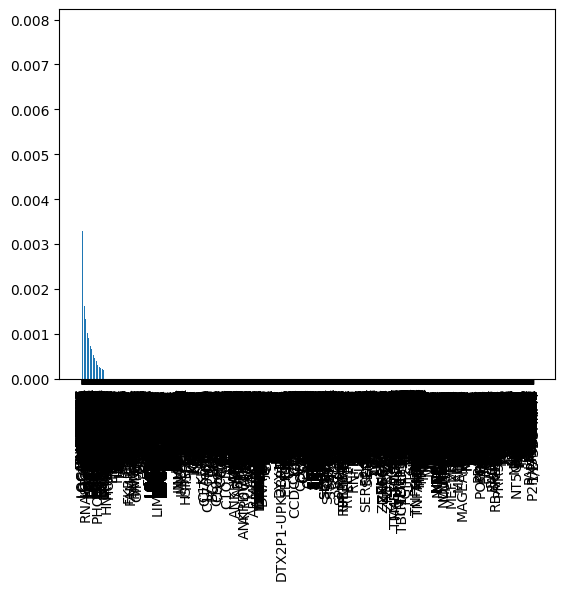

In [30]:
#let's now find the most important features
indices = np.argsort(importances)[::-1]
features = X.columns
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
#saving the plot
plt.savefig('feature_importance_1.png')

plt.show()


Well, that plot is too difficult to read, and doesn't help with our analysis. Let's try a different approach.

In [31]:
feat_imp_death = pd.DataFrame({'feature':features, 
                         'importance':importances}).sort_values(by='importance', ascending=False)

top20_death = feat_imp_death[:20]

print(top20_death)

            feature  importance
14502        NUDCD1    0.007842
5236          DSCC1    0.006979
21640         UBE2S    0.006818
14295          NOL8    0.006394
160            ACN9    0.005181
9914   LOC100128288    0.005109
20776      TMEM191B    0.004789
15426          PCNA    0.004684
18579       SLC22A4    0.004643
1654          BRIP1    0.004211
15226         PALB2    0.004202
18948          SMG6    0.004151
21797       UQCRFS1    0.003867
970       ARHGEF10L    0.003864
20777      TMEM191C    0.003795
17747          RRM1    0.003760
5543          EIF5B    0.003750
5062         DNAJA2    0.003696
3069         CCDC34    0.003650
15223          PAK4    0.003645


Let's also identify the most significant statistics for death using univariate analysis.

In [32]:
#importing libraries
from scipy import stats 
from sklearn.feature_selection import f_classif, chi2

In [33]:
f_values, p_values = f_classif(X, y)
chi2_values, p_chi2_values = chi2(X, y)

C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   17   230   236 ... 22166 22413 23069] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [34]:
f_results = pd.DataFrame({'feature':X.columns, 
                          'f_value':f_values, 
                          'p_value':p_values})

chi2_results = pd.DataFrame({'feature':X.columns,  
                             'chi2':chi2_values,
                             'p_chi2':p_chi2_values})

In [35]:
f_results.sort_values(by='p_value', ascending=True) 
chi2_results.sort_values(by='p_chi2', ascending=True)

,feature,chi2,p_chi2
8229,HOXD11,108.803951,1.791580e-25
13118,MIR770,86.144374,1.672671e-20
15213,PAGE5,85.716887,2.076322e-20
13639,MYCNOS,82.950374,8.413943e-20
19131,SNORA76,79.208078,5.590104e-19
...,...,...,...
22034,VTRNA1-3,NaN,NaN
22035,VTRNA2-1,NaN,NaN
22166,WFDC9,NaN,NaN
22413,ZCCHC13,NaN,NaN


In [36]:
f_results.sort_values(by='p_value', ascending=True, inplace=True)
chi2_results.sort_values(by='p_chi2', ascending=True, inplace=True)

f_top20 = f_results.head(20)  
chi2_top20 = chi2_results.head(20)

f_features = list(f_top20['feature'])
chi2_features = list(chi2_top20['feature'])

In [37]:
f_features

['CNIH4',
 'DKC1',
 'ACTL6A',
 'ERCC6L',
 'PPID',
 'WSB1',
 'CES4A',
 'HNRNPC',
 'SNAPC1',
 'CROCCP3',
 'KIF18A',
 'MRPL11',
 'TOM1L2',
 'PDHA1',
 'MAP3K12',
 'CSRP2',
 'ACN9',
 'MRPL3',
 'GMPS',
 'MAD2L1']

Clearly, the features vary between models. Let's build a full Logistic Regression model, and check it's performance.

In [39]:
#importing libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Creating a logistic regression model
logmodel_death = LogisticRegression(max_iter=1000)

#Training the model on the training data
logmodel_death.fit(X_train, y_train)

#Making predictions on the test data
y_pred = logmodel_death.predict(X_test)

#Checking the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

#Evaluating the model
print(classification_report(y_test, y_pred))


Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        39
           1       0.43      0.27      0.33        11

    accuracy                           0.76        50
   macro avg       0.62      0.59      0.59        50
weighted avg       0.73      0.76      0.74        50



Let's look at the confusion matrix and ROC curve.

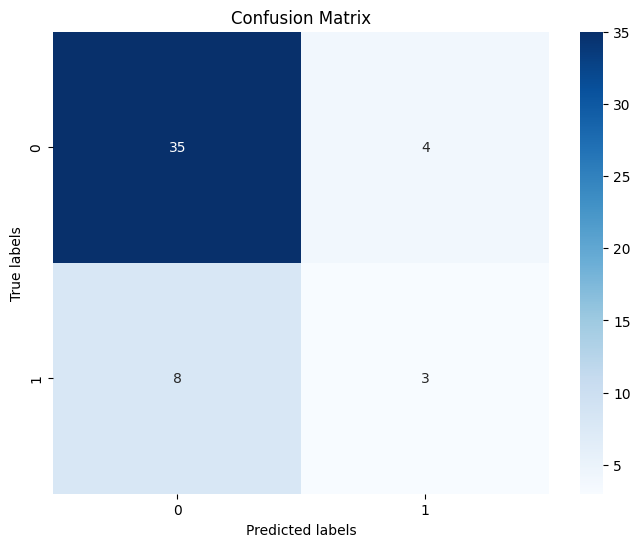

In [40]:
#importing libraries
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

#saving the plot
plt.savefig('confusion_matrix_logreg_death.png')

plt.show()



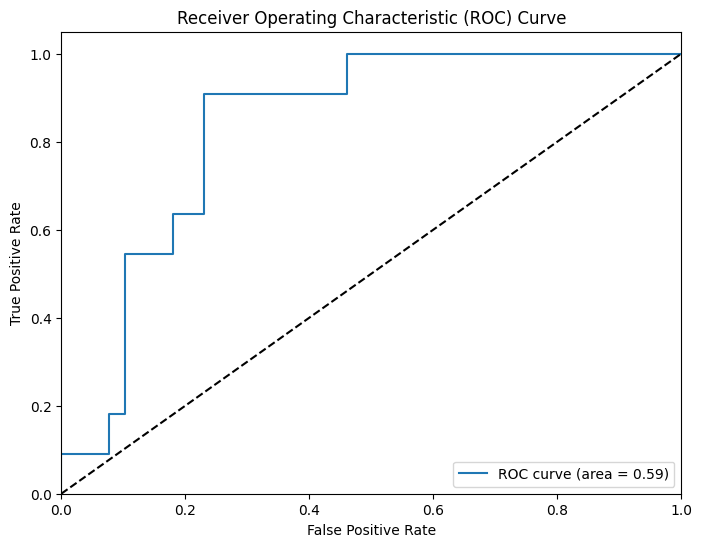

In [41]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, logmodel_death.predict_proba(X_test)[:,1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

#saving the plot
plt.savefig('roc_curve_logreg_death.png')

plt.show()



Area of 0.59 isn't great. but I want to try hyperparameter tuning. I tried using GridSearchCV, but the runtime was longer than an hour. Due to that, I'll try using RandomizedSearchCV instead, as it is known to be faster for large datasets. This did not prove fruitful as I kept running into convergence errors, even at 1000 iters. Due to this, I decided to move onto a different model. The code for the RandomizedSearchCV can be found below, but I've commented it out, just so that it can be observed, or for reference.

In [ ]:
# #importing libraries
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import uniform
# #Defining the hyperparameter distributions
# param_dist = {
#     'C': uniform(0.01, 100),  # Uniform distribution between 0.01 and 100
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga']
# }
# #Creating the RandomizedSearchCV object
# random_search = RandomizedSearchCV(LogisticRegression(max_iter=1000), param_dist, n_iter=1000, cv=5)
# #Performing the randomized search on the training data
# random_search.fit(X_train, y_train)
# #Getting the best hyperparameters
# best_params = random_search.best_params_
# print("Best Hyperparameters:", best_params)
# # Assuming random_search is your RandomizedSearchCV object
# best_params = random_search.best_params_

# #Creating a logistic regression model with the best hyperparameters
# best_model = LogisticRegression(**best_params, max_iter=1000)

# #Training the model
# best_model.fit(X_train, y_train)

# #Making predictions
# y_pred = best_model.predict(X_test)

# #Evaluating the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")


Let's try building a decision tree classifier model.

In [42]:
#importing libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [43]:
#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [44]:
#Creating the decision tree model
tree_model_death = DecisionTreeClassifier()

In [45]:
#Training the model
tree_model_death.fit(X_train, y_train)

DecisionTreeClassifier()

In [46]:
#Making predictions on the test data
y_pred = tree_model_death.predict(X_test)

In [48]:
#Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.84      0.79      0.82        39
           1       0.38      0.45      0.42        11

    accuracy                           0.72        50
   macro avg       0.61      0.62      0.62        50
weighted avg       0.74      0.72      0.73        50



Let's also visualise the tree.

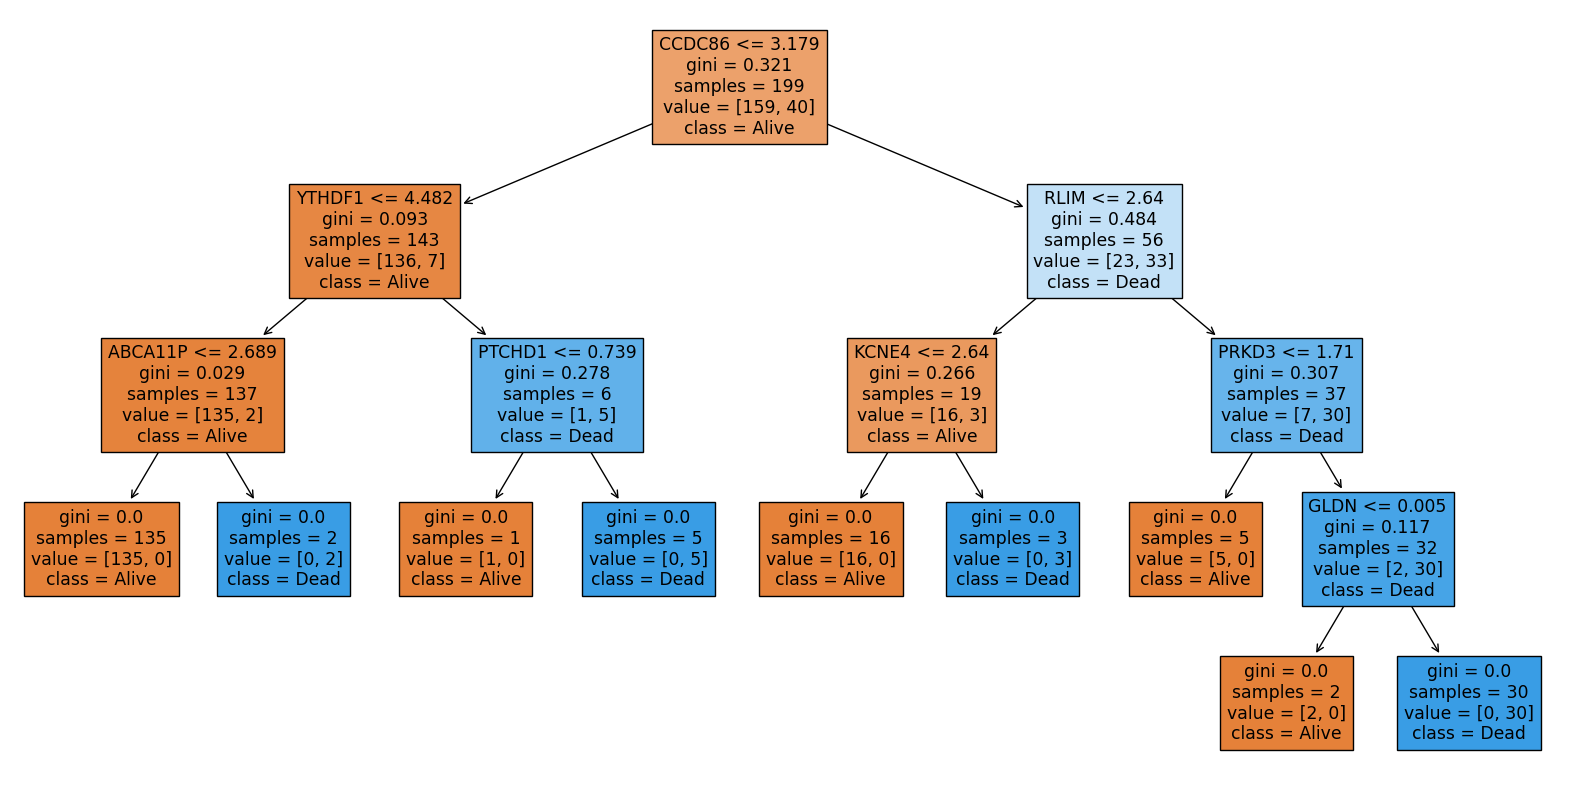

In [47]:
#Plotting the decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(tree_model_death, filled=True, feature_names=X.columns, class_names=['Alive', 'Dead'])

#saving the plot
plt.savefig('decision_tree_death.png')

plt.show()



Next, I'll try a support vector classifier.

In [49]:
#importing libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [50]:
#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Creating an SVC model
svc_model_death = SVC()

In [51]:
#Training the model
svc_model_death.fit(X_train, y_train)

#Making predictions on the test data
y_pred = svc_model_death.predict(X_test)

In [52]:
#Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        39
           1       0.00      0.00      0.00        11

    accuracy                           0.78        50
   macro avg       0.39      0.50      0.44        50
weighted avg       0.61      0.78      0.68        50



C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

The Support Vector Classifier model has a decent accuracy of 78%. I'll move on to looking at one of the other labels.

Next, I'll be looking at building models to predict the chance of a patient being considered high risk.


First, I'll try logistic regression.

In [53]:
#First, let's split the data into features and target
X = merged_df.drop('High Risk', axis=1)
# Columns to remove
cols_to_drop = ['ID', 'Sex', 'Age','Death', 'INSS', 'Progression'] 

# Drop columns
X = merged_df.drop(cols_to_drop, axis=1)  
y = merged_df['High Risk']  

In [54]:
#let's now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [55]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

In [56]:
logmodel_risk = LogisticRegression()
logmodel_risk.fit(X_train, y_train)

LogisticRegression()

In [57]:
y_pred = logmodel_risk.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        34
           1       0.79      0.94      0.86        16

    accuracy                           0.90        50
   macro avg       0.88      0.91      0.89        50
weighted avg       0.91      0.90      0.90        50

Accuracy: 0.9


Great! The accuracy of this model is 90% Let's now look at the confusion matrix and ROC curve of this model.

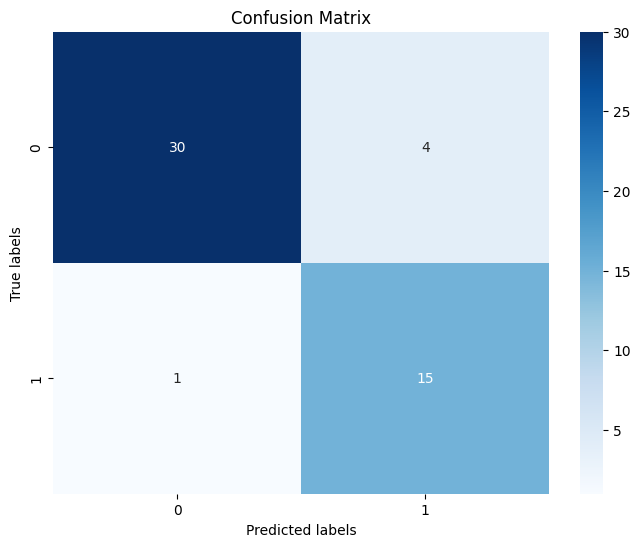

In [58]:
#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

#saving the plot
plt.savefig('confusion_matrix_logreg_risk.png')

plt.show()

In [59]:
# Calculate ROC curve and AUC
y_pred_proba = logmodel_risk.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

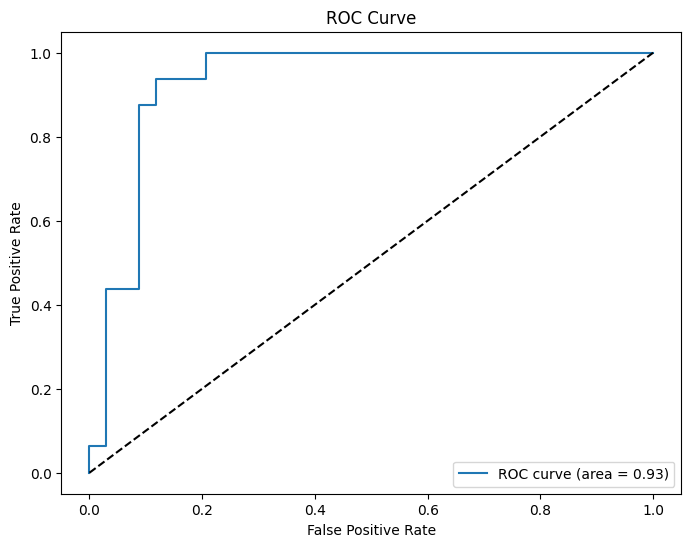

In [60]:
#Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

#saving the plot
plt.savefig('roc_curve_logreg_risk.png')

plt.show()

Next, I'll try a decision tree.

In [62]:
#importing libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [63]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)


In [64]:
#Creating a decision tree model
treemodel_risk = DecisionTreeClassifier()

#Training the model
treemodel_risk.fit(X_train, y_train)

#Making predictions
y_pred = treemodel_risk.predict(X_test)

#Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        16

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



The accuracy of the decision tree model is 100%. It also has a precision of 1, and a recall of 1. This means that the model is probably overfitting.

Still, let's visualise the decision tree.

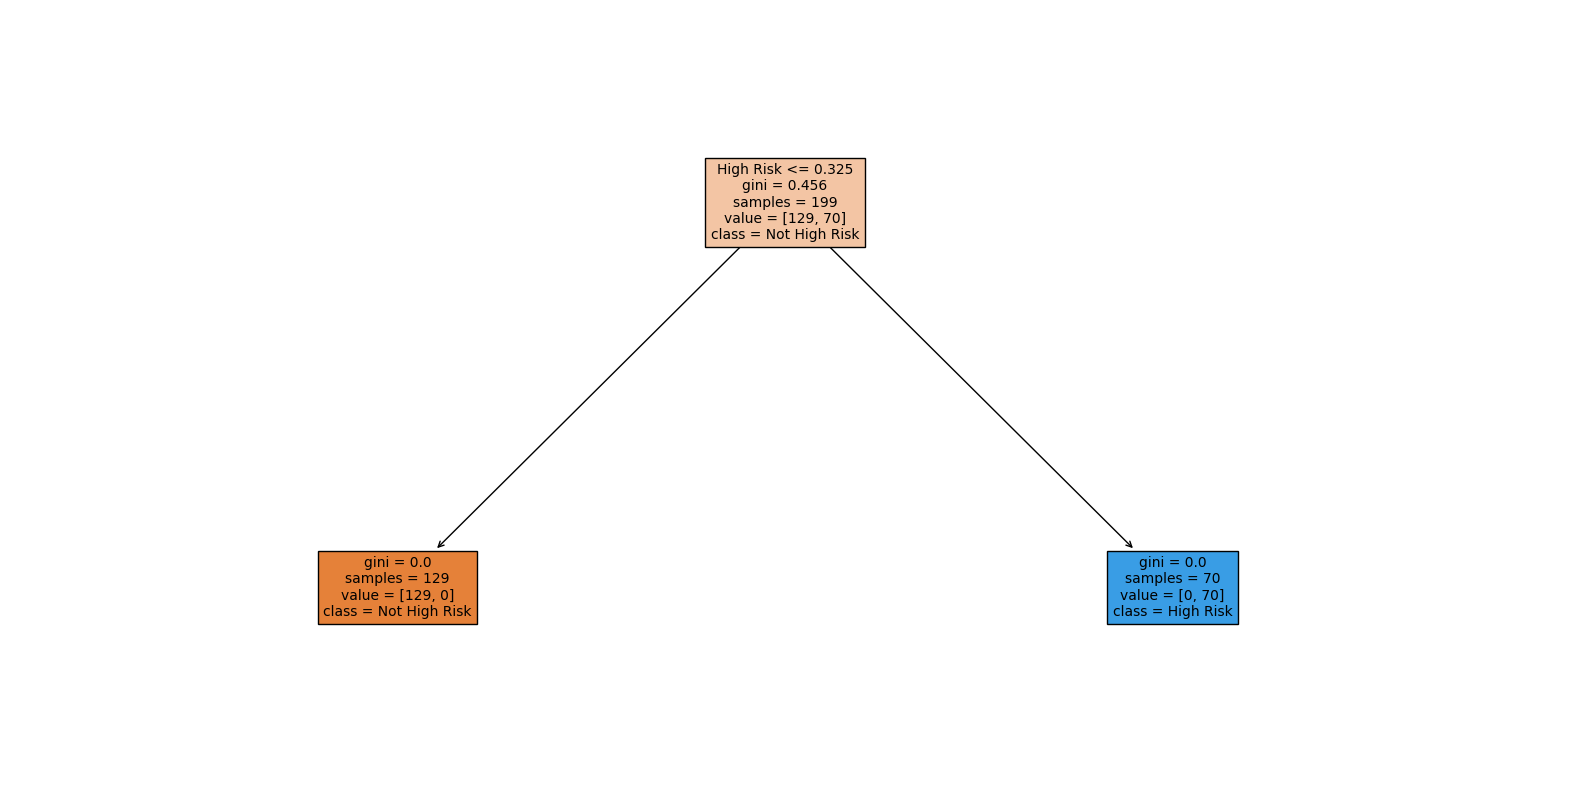

In [65]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

#Creating a figure and set its size
plt.figure(figsize=(20, 10))

# Plot the decision tree
plot_tree(treemodel_risk, feature_names=X.columns, class_names=['Not High Risk', 'High Risk'], filled=True, fontsize=10)

# Saving the plot
plt.savefig('decision_tree_risk.png')

# Display the plot
plt.show()

Clearly, the model is too simple for this type of analysis. Let's move on to support vector machines.

In [66]:
#loading libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

#Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

#Creating an SVM model
svm_model_risk = SVC()

#Training the model
svm_model_risk.fit(X_train, y_train)

#Making predictions on the test data
y_pred = svm_model_risk.predict(X_test)

#Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        34
           1       0.74      0.88      0.80        16

    accuracy                           0.86        50
   macro avg       0.84      0.86      0.85        50
weighted avg       0.87      0.86      0.86        50



Let's now look at building models to predict the chances of progression to a tumour.

As usual, let's first assign the features and the target variable, then scale and normalise the data.

In [67]:
X = merged_df.drop('Progression', axis=1)
# Columns to remove
cols_to_drop = ['ID', 'Sex', 'Age','Death', 'High Risk', 'INSS'] 

# Drop columns
X = merged_df.drop(cols_to_drop, axis=1)  
y = merged_df['Progression']  

In [68]:
#normalizing the data
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Now, let's build a logistic regression model.

In [69]:
#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Creating a logistic regression model
logreg_progression_model = LogisticRegression(max_iter=1000)

#Training the model on the training data
logreg_progression_model.fit(X_train, y_train)

#Making predictions on the test data
y_pred = logreg_progression_model.predict(X_test)

#Checking the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.76
              precision    recall  f1-score   support

           0       0.76      0.86      0.81        29
           1       0.76      0.62      0.68        21

    accuracy                           0.76        50
   macro avg       0.76      0.74      0.75        50
weighted avg       0.76      0.76      0.76        50



Let's now visualise the confusion matrix and ROC curve.

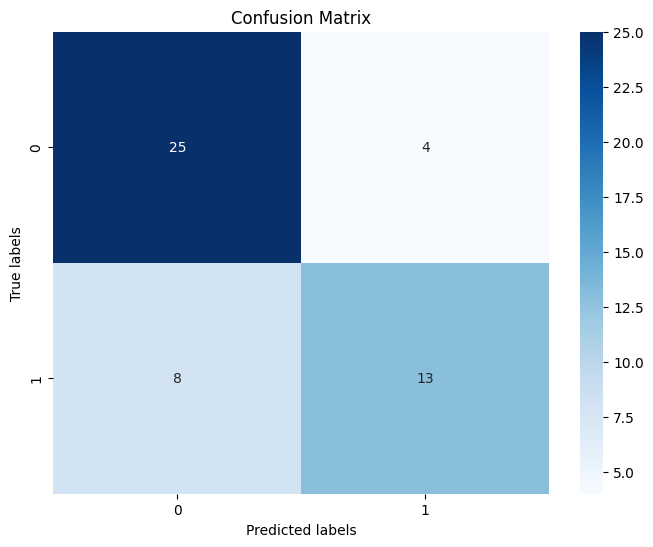

In [70]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

#saving the plot
plt.savefig('confusion_matrix_logreg_progression.png')

plt.show()

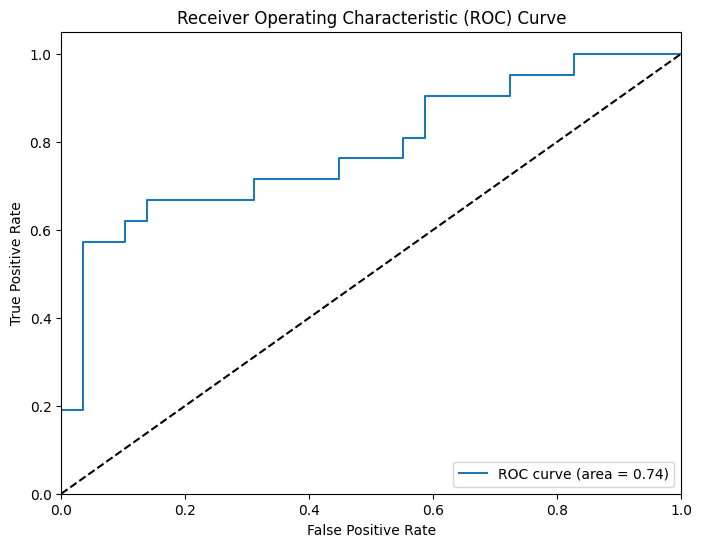

In [71]:
#Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logreg_progression_model.predict_proba(X_test)[:,1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

#saving the plot
plt.savefig('roc_curve_logreg_progression.png')

plt.show()

In [72]:
#Evaluating the model performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        29
           1       0.76      0.62      0.68        21

    accuracy                           0.76        50
   macro avg       0.76      0.74      0.75        50
weighted avg       0.76      0.76      0.76        50



Next, let's try a decision tree model.

In [73]:
#splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

#Creating a decision tree model
treemodel_progression = DecisionTreeClassifier()

#Training the model
treemodel_progression.fit(X_train, y_train)

#Making predictions
y_pred = treemodel_progression.predict(X_test)

#Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        21

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



The accuracy of the model is 100% and the accuracy and precision are perfect. This suggests the model could be overfitting. Let's visualise the decision tree.

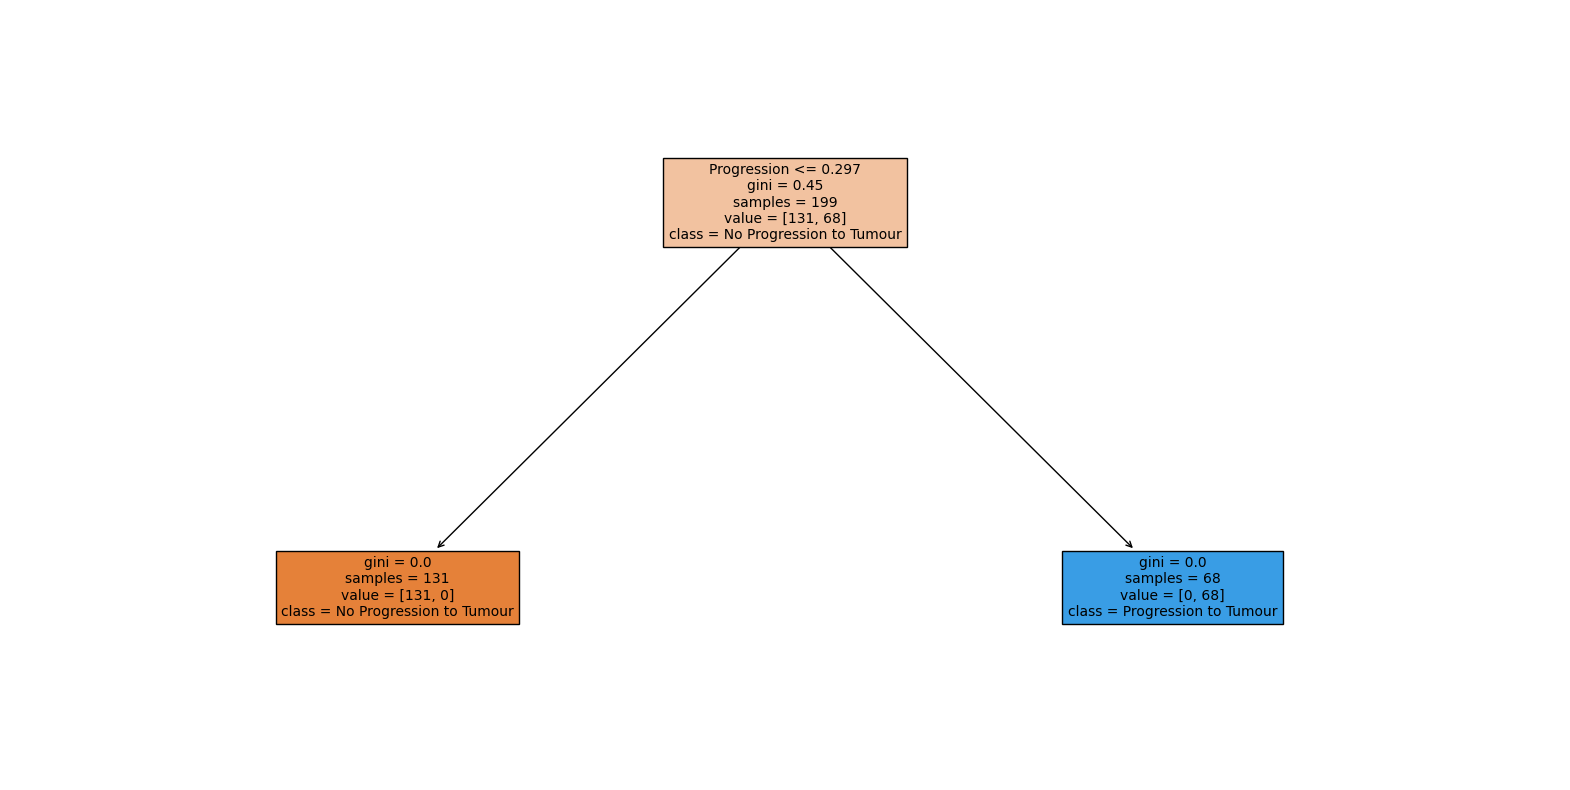

In [74]:
#Creating a figure and set its size
plt.figure(figsize=(20, 10))

# Plot the decision tree
plot_tree(treemodel_progression, feature_names=X.columns, class_names=['No Progression to Tumour', 'Progression to Tumour'], filled=True, fontsize=10)

# Saving the plot
plt.savefig('decision_tree_risk.png')

# Display the plot
plt.show()

Just like we saw earlier, the model is too simple for this type of analysis.

Let's try support vector machines.

In [75]:
#Creating an SVM model
svm_model_progression = SVC()

#Training the model
svm_model_progression.fit(X_train, y_train)

#Making predictions on the test data
y_pred = svm_model_progression.predict(X_test)

#Printing the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.90      0.83        29
           1       0.81      0.62      0.70        21

    accuracy                           0.78        50
   macro avg       0.79      0.76      0.76        50
weighted avg       0.78      0.78      0.77        50



The INSS Stage is the most complicated in our data. It takes into account surgery to remove a tumour, and evaluates the state of the neuroblastoma in the patient. Let's first look at all the values in the INSS Stage column.

In [76]:
#grouping the INSS column and counting the values
merged_df['INSS'].groupby(merged_df['INSS']).count()

INSS
1     29
2     14
3     18
4     28
1     31
2     26
3     12
4     63
4S    28
Name: INSS, dtype: int64

The documentation says that there are only 5 groups (1, 2, 3, 4 snd 4S), but it seems like there are 9. Let's see if we can group them into 5 groups, with 4S being defined as 5, for simplicity.

In [77]:
#grouping into 5 groups, by merging the groups with the same INSS labels
merged_df['INSS'] = merged_df['INSS'].replace(['1', '2', '3', '4', '1', '2', '3', '4', '4S'], [1, 2, 3, 4, 1, 2, 3, 4, 5])

In [78]:
#grouping the INSS column and counting the values
merged_df['INSS'].groupby(merged_df['INSS']).count()

INSS
1    60
2    40
3    30
4    91
5    28
Name: INSS, dtype: int64

That seems to have fixed the issue. Let's move on to building predictive models.

Due to the INSS Label being a multi-class variable, we cannot use a logistic regression model. Let's try a random forest model.

In [79]:
# Define the mapping of old column names to new column names
X = merged_df.drop('INSS', axis=1)
# Columns to remove
cols_to_drop = ['ID', 'Sex', 'Age','Death', 'High Risk', 'Progression'] 

# Drop columns
X = merged_df.drop(cols_to_drop, axis=1)  
y = merged_df['INSS']  

In [80]:
#let's now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [81]:
# Splitting the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [82]:
# Initialize the Random Forest Classifier
rf_classifier_INSS = RandomForestClassifier(n_estimators=100, random_state=1)

In [83]:
# Train the model on the training data
rf_classifier_INSS.fit(X_train, y_train)
# Make predictions on the test data
y_pred = rf_classifier_INSS.predict(X_test)

In [84]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print the classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.54
              precision    recall  f1-score   support

           1       0.33      0.70      0.45        10
           2       0.50      0.25      0.33         8
           3       0.00      0.00      0.00        10
           4       0.71      0.89      0.79        19
           5       1.00      0.33      0.50         3

    accuracy                           0.54        50
   macro avg       0.51      0.44      0.42        50
weighted avg       0.48      0.54      0.47        50



C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

The accuracy is too low, let's try a decision tree model.

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        19
           5       1.00      1.00      1.00         3

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50


Confusion Matrix:
 [[10  0  0  0  0]
 [ 0  8  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 19  0]
 [ 0  0  0  0  3]]


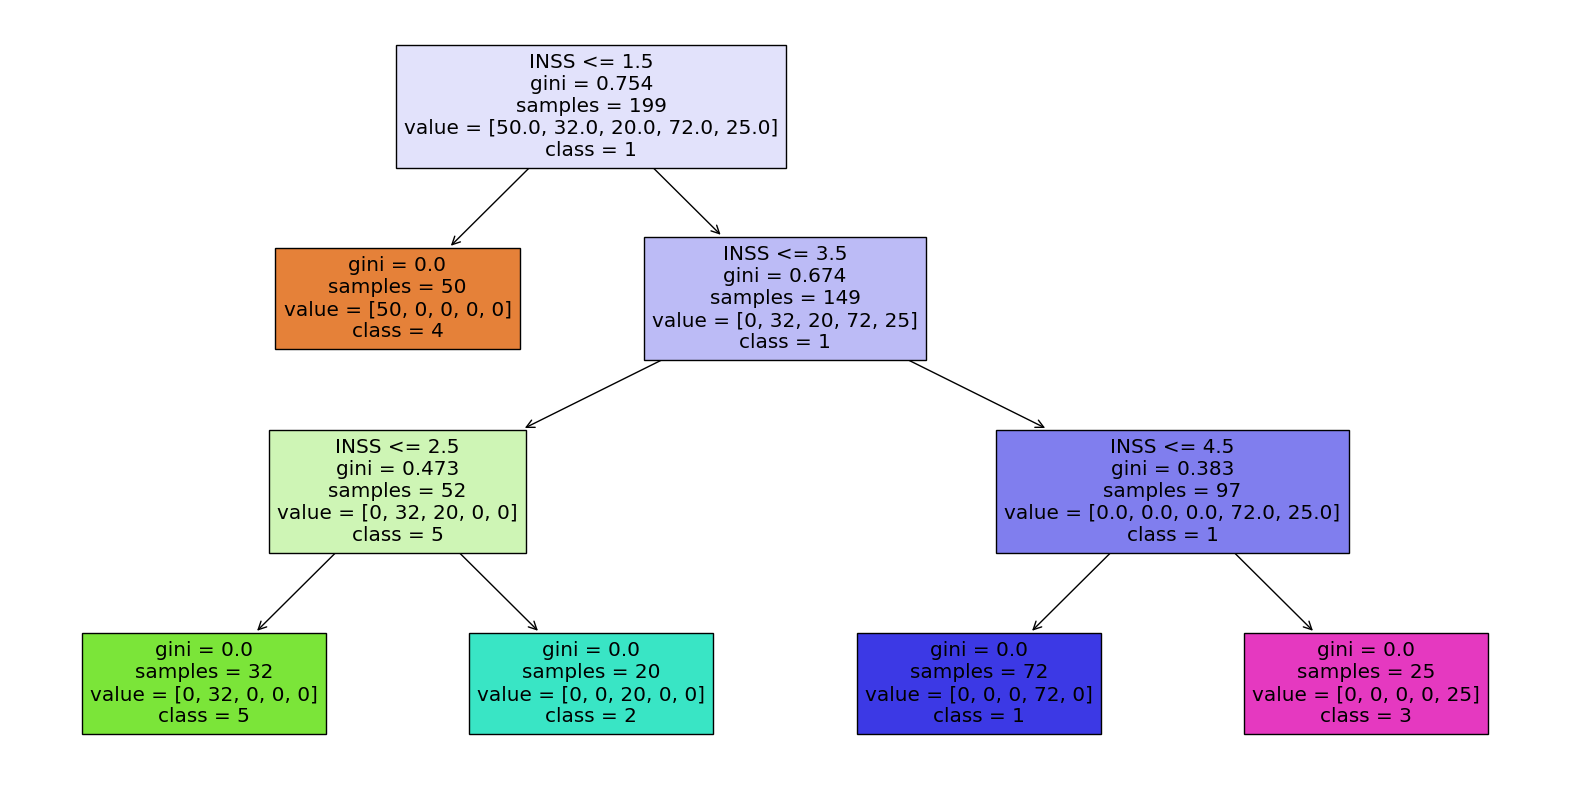

In [85]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Instantiate the Decision Tree Classifier
dt_classifier_INSS = DecisionTreeClassifier(random_state=42)

# Train the Classifier
dt_classifier_INSS.fit(X_train, y_train)

# Make Predictions
y_pred = dt_classifier_INSS.predict(X_test)

# Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualising the Decision Tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Convert y.unique() to strings
class_names = y.unique().astype(str)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_classifier_INSS, filled=True, feature_names=X.columns, class_names=class_names)

#saving the plot
plt.savefig('decision_tree_INSS.png') 

plt.show()


The decision tree model has an accuracy of 100%, which suggests that the model is overfitting. Let's try something different, like a support vector machine.

In [86]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Instantiate the SVC
svc_classifier_INSS = SVC(kernel='rbf', random_state=1)

# Train the Classifier
svc_classifier_INSS.fit(X_train, y_train)

# Make Predictions
y_pred = svc_classifier_INSS.predict(X_test)

# Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.5

Classification Report:
               precision    recall  f1-score   support

           1       0.29      0.80      0.42        10
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        10
           4       0.77      0.89      0.83        19
           5       0.00      0.00      0.00         3

    accuracy                           0.50        50
   macro avg       0.21      0.34      0.25        50
weighted avg       0.35      0.50      0.40        50



C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Muthu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

The accuracy is only 50%, with very low f1 scores. Still, let's visualise the confusion matrix.

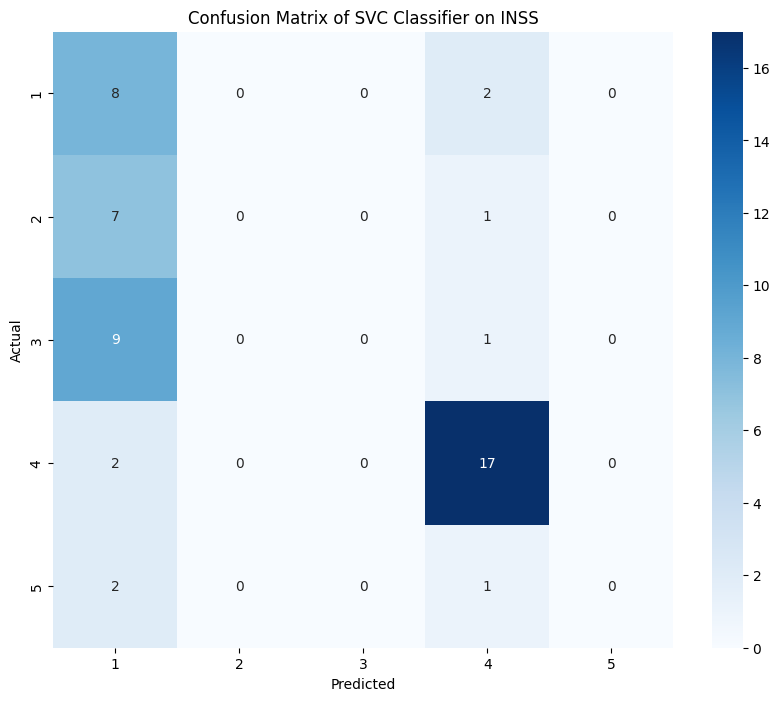

In [87]:
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix
cm_df = pd.DataFrame(cm, index=svc_classifier_INSS.classes_, columns=svc_classifier_INSS.classes_)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of SVC Classifier on INSS')

#saving the plot
plt.savefig('confusion_matrix_SVclassifier_INSS.png')
plt.show()

This model isn't very reliable. Perhaps we can try a neural network.

In [88]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Adjust the class labels to start from 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# Convert the target variable to categorical
y_train_categorical = to_categorical(y_train_adjusted, num_classes=5)  
y_test_categorical = to_categorical(y_test_adjusted, num_classes=5)    

# Building the neural network model
nn_model_INSS = Sequential()
nn_model_INSS.add(Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)))
nn_model_INSS.add(Dense(64, activation='relu'))
nn_model_INSS.add(Dense(5, activation='softmax'))  # 5 classes for INSS staging

# Compiling the model
nn_model_INSS.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = nn_model_INSS.fit(X_train_scaled, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_categorical))

# Evaluating the model
loss, accuracy = nn_model_INSS.evaluate(X_test_scaled, y_test_categorical)
print(f"Test Accuracy: {accuracy}")





Epoch 1/50


7/7 [==============================] - 1s 48ms/step - loss: 3.4328 - accuracy: 0.3719 - val_loss: 13094.7539 - val_accuracy: 0.4200
Epoch 2/50
7/7 [==============================] - 0s 25ms/step - loss: 1.4612 - accuracy: 0.7387 - val_loss: 13133.0439 - val_accuracy: 0.6000
Epoch 3/50
7/7 [==============================] - 0s 25ms/step - loss: 0.4619 - accuracy: 0.8995 - val_loss: 13057.1377 - val_accuracy: 0.6200
Epoch 4/50
7/7 [==============================] - 0s 24ms/step - loss: 0.0567 - accuracy: 0.9799 - val_loss: 12706.3184 - val_accuracy: 0.5800
Epoch 5/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 12520.6338 - val_accuracy: 0.5600
Epoch 6/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 11774.5342 - val_accuracy: 0.5800
Epoch 7/50
7/7 [==============================] - 0s 25ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 11292.0117 - val_accuracy: 0

An accuracy of 60% is decent, and it's the best so far.

# Model Selection

Based on the performances of the models, I'm choosing the best performing model for each label.

## Death Prediction
The logistic regression model had the best performance, with an accuracy of 0.76 and f1 score of 0.74. I'll use this model for death prediction.

logmodel_death

## High Risk Prediction
The logistic regression model had the best performance, with an accuracy of 0.90 and f1 score of 0.90. I'll use this model for risk prediction.

logmodel_risk

## Progression to Tumour Prediction
The support vector classifier model had the best performance, with an accuracy of 0.78 and f1 score of 0.77. I'll use this model for progression to tumour prediction.

svm_model_progression

## INSS Stage Prediction
The neural network model had the best performance, with an accuracy of 0.6. I'll use this model for INSS stage prediction.

I'm going to save the models to be used later on for prediction. I'll be using joblib to save the models.

In [90]:
import os
import joblib

# Create a directory to store the models if it doesn't exist
directory = 'models'
if not os.path.exists(directory):
    os.makedirs(directory)

# Save the models to the 'models' directory
joblib.dump(logmodel_death, os.path.join(directory, 'logmodel_death.pkl'))
joblib.dump(logmodel_risk, os.path.join(directory, 'logmodel_risk.pkl'))
joblib.dump(svm_model_progression, os.path.join(directory, 'svm_model_progression.pkl'))
joblib.dump(nn_model_INSS, os.path.join(directory, 'nn_model_INSS.pkl'))



['models\\nn_model_INSS.pkl']

Let's now build a dataframe with the test data and the RNA Seq data so that we can make predictions.

In [93]:
#first, let's open patientInfo_test.tsv as a dataframe
patientInfo_test_df = pd.read_csv('patientInfo_test.tsv', sep='\t')

In [95]:
# Merge on PatientID  
merged_test = patientInfo_test_df.merge(expr, on='ID')

In [97]:
# Sort by column: 'ID' (ascending)
merged_test = merged_test.sort_values(['ID'])
#fixing the index
merged_test = merged_test.reset_index(drop=True)

In [101]:
#renaming the columns in merged.tsv to make them readable
column_map2 = {'FactorValue..Sex.': 'Sex',
             'FactorValue..age.at.diagnosis.': 'Age',
             'FactorValue..death.from.disease.': 'Death',
             'FactorValue..high.risk.': 'High Risk',
             'FactorValue..inss.stage.': 'INSS',
             'FactorValue..progression.': 'Progression'}

merged_test = merged_test.rename(columns=column_map2)


In [102]:
#saving the merged dataframe as a tsv file
merged_test.to_csv('merged_test.tsv', sep='\t')